In [ ]:
#Data Cleaning

import pandas as pd
import numpy as np

# 1. Load the dataset
df = pd.read_csv("Traffic_Collisions_Open_Data_3719442797094142699.csv")

# 2. Remove entries where HOOD or NEIGHBOURHOOD are "NSA"
df = df[
    (df["HOOD_158"] != "NSA") &
    (df["NEIGHBOURHOOD_158"] != "NSA") &
    (df["DIVISION"] != "NSA") &
    (df["AUTOMOBILE"] != "N/R") &
    (df["MOTORCYCLE"] != "N/R") &
    (df["BICYCLE"] != "N/R") &
    (df["PEDESTRIAN"] != "N/R")
]

# 3. Remove any rows with missing data in ANY remaining column
df = df.dropna()

# 4. Create the new 'severity' classification
#    - severe: any fatalities OR any injuries
#    - non-severe: everything else
df["SEVERITY"] = np.where(
    (df["FATALITIES"] > 0) | (df["INJURY_COLLISIONS"] == "YES"),
    "SEVERE",
    "NON-SEVERE"
)

# 5. Drop the original severity-related columns
df = df.drop(columns=["FATALITIES", "INJURY_COLLISIONS", "PD_COLLISIONS", "EVENT_UNIQUE_ID", "OCC_DATE"])

# 6. Optional: save the cleaned, modified dataset
df.to_csv("Traffic_Collisions_clean_severity_no_NSA_hood.csv", index=False)

# Quick peek
df.head()
print("=== BASIC STATISTICS ===")
print("\nDataset Info:")
print(df.info())

print("\n=== DESCRIPTIVE STATISTICS FOR NUMERICAL COLUMNS ===")
print(df.describe())

print("\n=== MISSING DATA ANALYSIS ===")
print("Missing values per column:")
print(df.isnull().sum())

print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Percentage of missing data: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")

print("\n=== DATA TYPES ===")
print(df.dtypes)
print(df["SEVERITY"].value_counts())

neighbourhood_table = (
    df["NEIGHBOURHOOD_158"]
    .value_counts()
    .reset_index()
)

neighbourhood_table.columns = ["Neighbourhood", "Crash_Count"]

display(neighbourhood_table.head(10))


=== BASIC STATISTICS ===

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 642036 entries, 0 to 772514
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   OBJECTID           642036 non-null  int64  
 1   OCC_MONTH          642036 non-null  object 
 2   OCC_DOW            642036 non-null  object 
 3   OCC_YEAR           642036 non-null  int64  
 4   OCC_HOUR           642036 non-null  int64  
 5   DIVISION           642036 non-null  object 
 6   FTR_COLLISIONS     642036 non-null  object 
 7   HOOD_158           642036 non-null  object 
 8   NEIGHBOURHOOD_158  642036 non-null  object 
 9   LONG_WGS84         642036 non-null  float64
 10  LAT_WGS84          642036 non-null  float64
 11  AUTOMOBILE         642036 non-null  object 
 12  MOTORCYCLE         642036 non-null  object 
 13  PASSENGER          642036 non-null  object 
 14  BICYCLE            642036 non-null  object 
 15  PEDESTRIAN      

,Neighbourhood,Crash_Count
0,Wexford/Maryvale (119),18904
1,West Humber-Clairville (1),15492
2,York University Heights (27),12656
3,St Lawrence-East Bayfront-The Islands (166),10784
4,Dorset Park (126),10712
5,Etobicoke City Centre (159),10362
6,Banbury-Don Mills (42),10340
7,Milliken (130),10070
8,Yorkdale-Glen Park (31),9909
9,Yonge-Bay Corridor (170),9594


In [ ]:
# Feature Analysis

# Target (no one-hot needed)
y = df["SEVERITY"]

# Features
x = df.drop(columns=["SEVERITY"])

# One-hot encode *feature* columns that are strings
cat_cols = x.select_dtypes(include=["object", "string"]).columns
x_encoded = pd.get_dummies(x, columns=cat_cols, drop_first=False)

print("Categorical columns being one-hot encoded:")
print(cat_cols)




Categorical columns being one-hot encoded:
Index(['OCC_MONTH', 'OCC_DOW', 'DIVISION', 'FTR_COLLISIONS', 'HOOD_158',
       'NEIGHBOURHOOD_158', 'AUTOMOBILE', 'MOTORCYCLE', 'PASSENGER', 'BICYCLE',
       'PEDESTRIAN'],
      dtype='object')


In [ ]:
# Train, validation, test split

from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(
    x_encoded,y, test_size=0.3, random_state=42
    )

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=1/3, random_state=42
)

print(f"Train size: {x_train.shape[0]}")
print(f"Validation size: {x_val.shape[0]}")
print(f"Test size: {x_test.shape[0]}")

Generating learning curve...


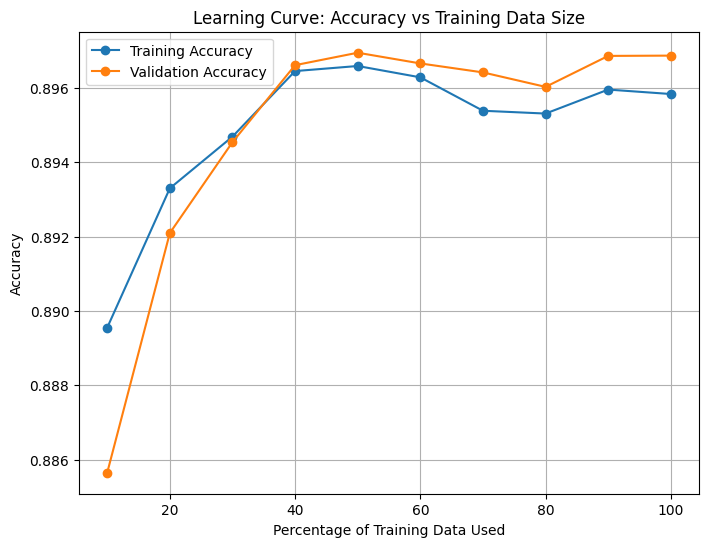

<Figure size 500x400 with 0 Axes>

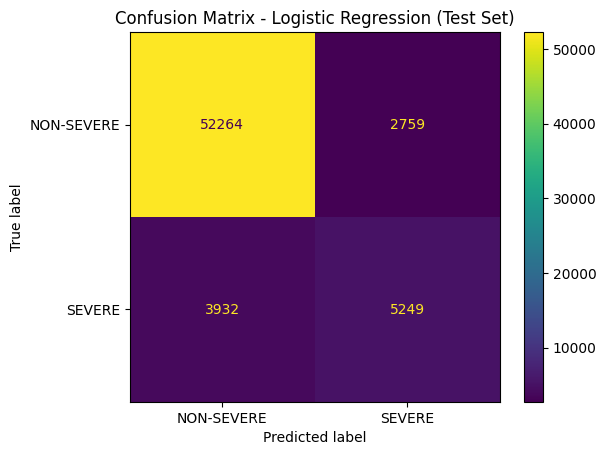

Accuracy : 0.8958
Precision: 0.6555
Recall   : 0.5717
F1-score : 0.6107
AUC-ROC  : 0.8294


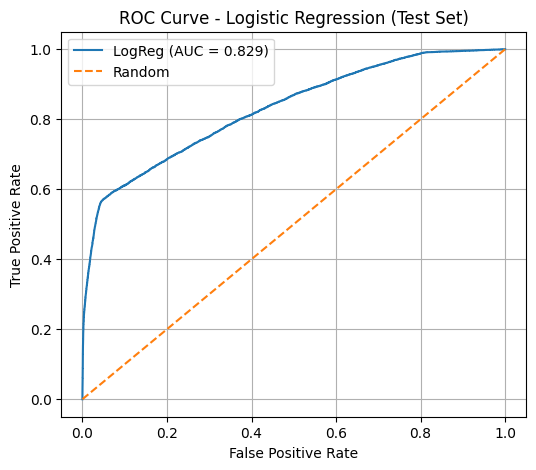

In [ ]:
# Logistic Regression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

# Build pipeline: scale → logistic regression
log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

import numpy as np

train_sizes = np.linspace(0.1, 1.0, 10) # 10 steps from 10% to 100% data
train_accuracies = []
val_accuracies = []

print("Generating learning curve...")

for fraction in train_sizes:
    # Determine the number of samples for this step
    size = int(len(x_train) * fraction)

    # Slice the training data (handles both Pandas and Numpy)
    if hasattr(x_train, "iloc"):
        x_subset = x_train.iloc[:size]
        y_subset = y_train.iloc[:size]
    else:
        x_subset = x_train[:size]
        y_subset = y_train[:size]

    # Clone/Create a fresh pipeline to ensure we start from scratch
    # (We re-use the definition of log_reg_pipe provided above)
    model = log_reg_pipe

    # Fit on the subset
    model.fit(x_subset, y_subset)

    # Record Training Accuracy (on the subset used for training)
    train_pred_subset = model.predict(x_subset)
    train_accuracies.append(accuracy_score(y_subset, train_pred_subset))

    # Record Validation Accuracy (on the FULL fixed validation set)
    val_pred = model.predict(x_val)
    val_accuracies.append(accuracy_score(y_val, val_pred))

# Plot the Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * 100, train_accuracies, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(train_sizes * 100, val_accuracies, label='Validation Accuracy', marker='o', linestyle='-')

plt.title('Learning Curve: Accuracy vs Training Data Size')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Train on Fulltraining set
log_reg_pipe.fit(x_train, y_train)

# Evaluate on validation set
y_val_pred = log_reg_pipe.predict(x_val)


# --- Predictions ---
y_test_pred = log_reg_pipe.predict(x_test)

# For ROC/AUC we need predicted probabilities for the positive class ("SEVERE")
# Pipeline has classes_ in order, so we find the index of "SEVERE"
class_index = list(log_reg_pipe.classes_).index("SEVERE")
y_test_proba = log_reg_pipe.predict_proba(x_test)[:, class_index]

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_test_pred, labels=["NON-SEVERE", "SEVERE"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["NON-SEVERE", "SEVERE"])
plt.figure(figsize=(5,4))
disp.plot(values_format="d")
plt.title("Confusion Matrix - Logistic Regression (Test Set)")
plt.show()

# --- Metrics ---
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label="SEVERE")
recall = recall_score(y_test, y_test_pred, pos_label="SEVERE")
f1 = f1_score(y_test, y_test_pred, pos_label="SEVERE")
auc = roc_auc_score((y_test == "SEVERE").astype(int), y_test_proba)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}")

# Compute ROC curve
y_test_bin = (y_test == "SEVERE").astype(int)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_test_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


Training for 100 epochs...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

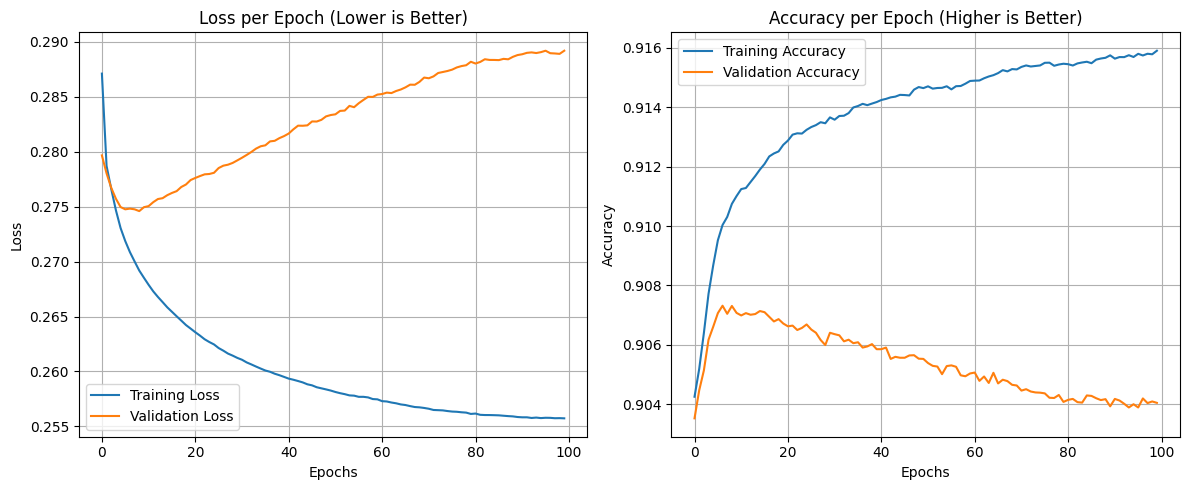

NameError: name 'confusion_matrix' is not defined

In [ ]:
# ============================
# Neural Network (MLP)
# ============================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Build pipeline: scale → MLP
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64, 32),  # you can tweak this
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        max_iter=100,
        random_state=42
    ))
])

import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

# --- PRE-PROCESSING ---
# Because we are doing a manual loop, we need to scale the data FIRST
# so we don't re-scale it 100 times inside the loop.
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test) # Scale test set for later too

# --- SETUP THE MODEL ---
# Note: We removed the Pipeline here because we manually scaled above.
# We set warm_start=True so it remembers weights between loops.
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    learning_rate_init=0.001,
    random_state=42,
    warm_start=True,  # <--- CRITICAL: Keep memory between loops
    max_iter=1        # <--- CRITICAL: One epoch at a time
)

# --- MANUAL TRAINING LOOP ---
n_epochs = 100
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

print(f"Training for {n_epochs} epochs...")

for epoch in range(n_epochs):
    # Fit for 1 epoch
    mlp.fit(x_train_scaled, y_train)

    # 1. Record Training Loss (Scikit-learn calculates this automatically)
    train_loss_history.append(mlp.loss_)

    # 2. Calculate & Record Validation Loss manually
    # We use log_loss (Cross-Entropy) to compare with the training loss
    val_probs = mlp.predict_proba(x_val_scaled)
    val_loss = log_loss(y_val, val_probs)
    val_loss_history.append(val_loss)

    # 3. (Optional) Record Accuracy just to see
    train_acc_history.append(mlp.score(x_train_scaled, y_train))
    val_acc_history.append(mlp.score(x_val_scaled, y_val))

# --- PLOTTING THE OVERFITTING CURVE ---
plt.figure(figsize=(12, 5))

# Plot 1: Loss Curve (The best way to spot overfitting)
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss per Epoch (Lower is Better)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy Curve (Easier to read)
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Accuracy per Epoch (Higher is Better)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Predictions on test set ---
y_test_pred_mlp = mlp.predict(x_test_scaled)

# For ROC/AUC we need predicted probabilities for "SEVERE"
class_index_mlp = list(mlp.classes_).index("SEVERE")
y_test_proba_mlp = mlp.predict_proba(x_test_scaled)[:, class_index_mlp]


<Figure size 500x400 with 0 Axes>

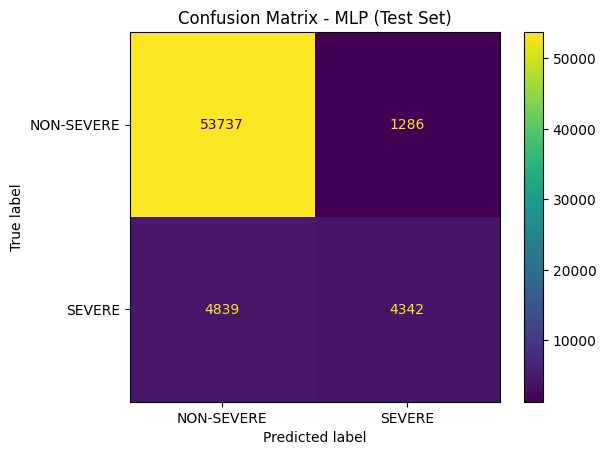

=== MLP Performance on Test Set ===
Accuracy : 0.9046
Precision: 0.7715
Recall   : 0.4729
F1-score : 0.5864
AUC-ROC  : 0.8247


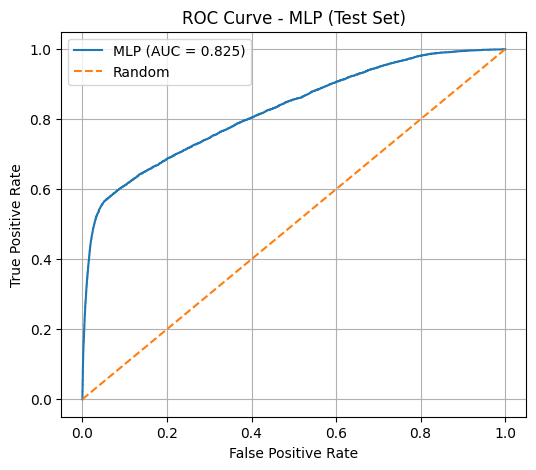

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
# --- Confusion matrix ---
cm_mlp = confusion_matrix(y_test, y_test_pred_mlp, labels=["NON-SEVERE", "SEVERE"])
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp,
                                  display_labels=["NON-SEVERE", "SEVERE"])
plt.figure(figsize=(5,4))
disp_mlp.plot(values_format="d")
plt.title("Confusion Matrix - MLP (Test Set)")
plt.show()

# --- Metrics ---
accuracy_mlp  = accuracy_score(y_test, y_test_pred_mlp)
precision_mlp = precision_score(y_test, y_test_pred_mlp, pos_label="SEVERE")
recall_mlp    = recall_score(y_test, y_test_pred_mlp, pos_label="SEVERE")
f1_mlp        = f1_score(y_test, y_test_pred_mlp, pos_label="SEVERE")
auc_mlp       = roc_auc_score((y_test == "SEVERE").astype(int), y_test_proba_mlp)

print("=== MLP Performance on Test Set ===")
print(f"Accuracy : {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall   : {recall_mlp:.4f}")
print(f"F1-score : {f1_mlp:.4f}")
print(f"AUC-ROC  : {auc_mlp:.4f}")

# --- ROC curve ---
y_test_bin = (y_test == "SEVERE").astype(int)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_bin, y_test_proba_mlp)

plt.figure(figsize=(6,5))
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {auc_mlp:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 500x400 with 0 Axes>

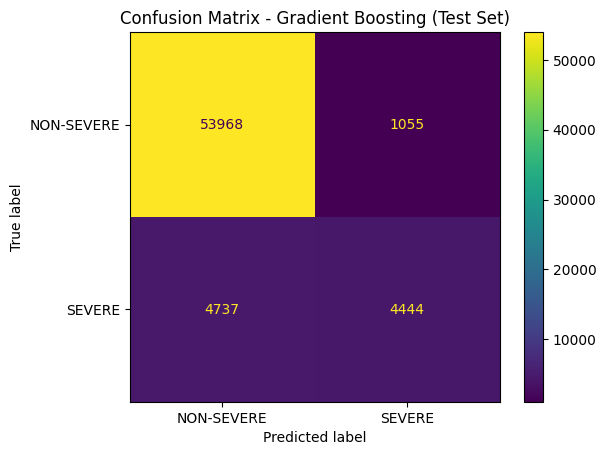

=== Gradient Boosting Performance on Test Set ===
Accuracy : 0.9098
Precision: 0.8081
Recall   : 0.4840
F1-score : 0.6054
AUC-ROC  : 0.8432


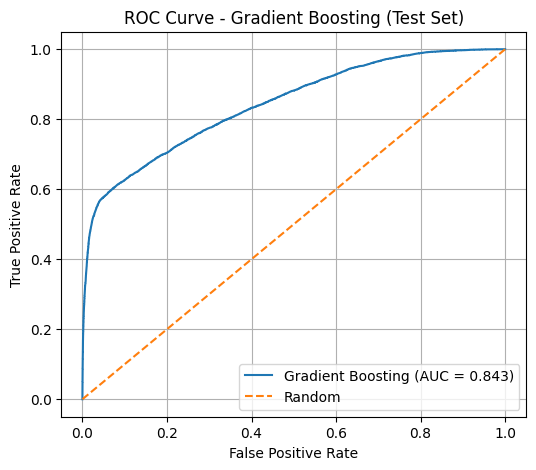

In [ ]:
# ============================
# Gradient Boosting Classifier
# ============================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import numpy as np

# Build pipeline: (scaler is optional for trees, but harmless)
gb_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False for sparse safety
    ("gb", GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=200,
        max_depth=3,
        random_state=42
    ))
])

# Train on training set
gb_pipe.fit(x_train, y_train)

# --- Predictions on test set ---
y_test_pred_gb = gb_pipe.predict(x_test)

# For ROC/AUC we need predicted probabilities for "SEVERE"
class_index_gb = list(gb_pipe.classes_).index("SEVERE")
y_test_proba_gb = gb_pipe.predict_proba(x_test)[:, class_index_gb]

# --- Confusion matrix ---
cm_gb = confusion_matrix(y_test, y_test_pred_gb, labels=["NON-SEVERE", "SEVERE"])
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb,
                                 display_labels=["NON-SEVERE", "SEVERE"])
plt.figure(figsize=(5,4))
disp_gb.plot(values_format="d")
plt.title("Confusion Matrix - Gradient Boosting (Test Set)")
plt.show()

# --- Metrics ---
accuracy_gb  = accuracy_score(y_test, y_test_pred_gb)
precision_gb = precision_score(y_test, y_test_pred_gb, pos_label="SEVERE")
recall_gb    = recall_score(y_test, y_test_pred_gb, pos_label="SEVERE")
f1_gb        = f1_score(y_test, y_test_pred_gb, pos_label="SEVERE")
auc_gb       = roc_auc_score((y_test == "SEVERE").astype(int), y_test_proba_gb)

print("=== Gradient Boosting Performance on Test Set ===")
print(f"Accuracy : {accuracy_gb:.4f}")
print(f"Precision: {precision_gb:.4f}")
print(f"Recall   : {recall_gb:.4f}")
print(f"F1-score : {f1_gb:.4f}")
print(f"AUC-ROC  : {auc_gb:.4f}")

# --- ROC curve ---
y_test_bin = (y_test == "SEVERE").astype(int)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test_bin, y_test_proba_gb)

plt.figure(figsize=(6,5))
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {auc_gb:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 500x400 with 0 Axes>

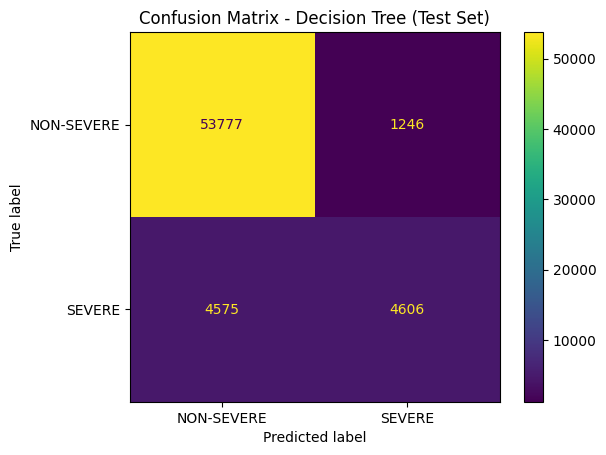

=== Decision Tree Performance on Test Set ===
Accuracy : 0.9093
Precision: 0.7871
Recall   : 0.5017
F1-score : 0.6128
AUC-ROC  : 0.8355


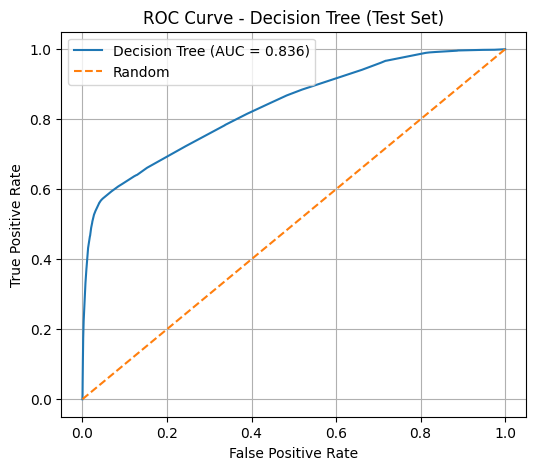

In [ ]:
# ===============================
# Decision Tree Classifier
# ===============================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import numpy as np

# Build pipeline (scaler is optional for trees)
dt_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # harmless, safe for sparse matrices
    ("dt", DecisionTreeClassifier(
        max_depth=10,       # reasonable depth to prevent overfitting
        min_samples_split=20,
        random_state=42
    ))
])

# Train on training set
dt_pipe.fit(x_train, y_train)

# --- Predictions on test set ---
y_test_pred_dt = dt_pipe.predict(x_test)

# For ROC/AUC we need predicted probabilities for "SEVERE"
class_index_dt = list(dt_pipe.classes_).index("SEVERE")
y_test_proba_dt = dt_pipe.predict_proba(x_test)[:, class_index_dt]

# --- Confusion matrix ---
cm_dt = confusion_matrix(y_test, y_test_pred_dt, labels=["NON-SEVERE", "SEVERE"])
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt,
                                 display_labels=["NON-SEVERE", "SEVERE"])
plt.figure(figsize=(5,4))
disp_dt.plot(values_format="d")
plt.title("Confusion Matrix - Decision Tree (Test Set)")
plt.show()

# --- Metrics ---
accuracy_dt  = accuracy_score(y_test, y_test_pred_dt)
precision_dt = precision_score(y_test, y_test_pred_dt, pos_label="SEVERE")
recall_dt    = recall_score(y_test, y_test_pred_dt, pos_label="SEVERE")
f1_dt        = f1_score(y_test, y_test_pred_dt, pos_label="SEVERE")
auc_dt       = roc_auc_score((y_test == "SEVERE").astype(int), y_test_proba_dt)

print("=== Decision Tree Performance on Test Set ===")
print(f"Accuracy : {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall   : {recall_dt:.4f}")
print(f"F1-score : {f1_dt:.4f}")
print(f"AUC-ROC  : {auc_dt:.4f}")

# --- ROC curve ---
y_test_bin = (y_test == "SEVERE").astype(int)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test_bin, y_test_proba_dt)

plt.figure(figsize=(6,5))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 500x400 with 0 Axes>

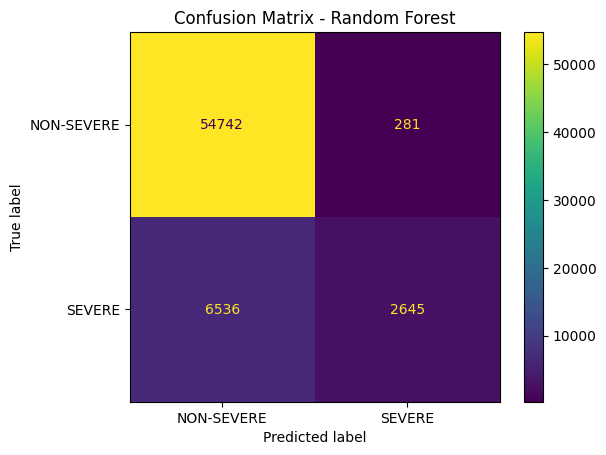


=== Random Forest Performance ===
Accuracy : 0.8938
Precision: 0.9040
Recall   : 0.2881
F1-score : 0.4369
AUC-ROC  : 0.8342


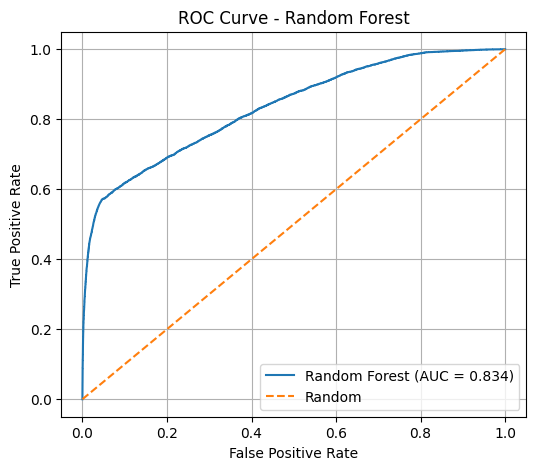


=== Features with Importance > 0.01 ===
           Feature  Importance
      PASSENGER_NO    0.202088
     PASSENGER_YES    0.187694
    PEDESTRIAN_YES    0.157882
     PEDESTRIAN_NO    0.150073
       BICYCLE_YES    0.097841
        BICYCLE_NO    0.072211
 FTR_COLLISIONS_NO    0.036640
FTR_COLLISIONS_YES    0.033064
          OBJECTID    0.011572


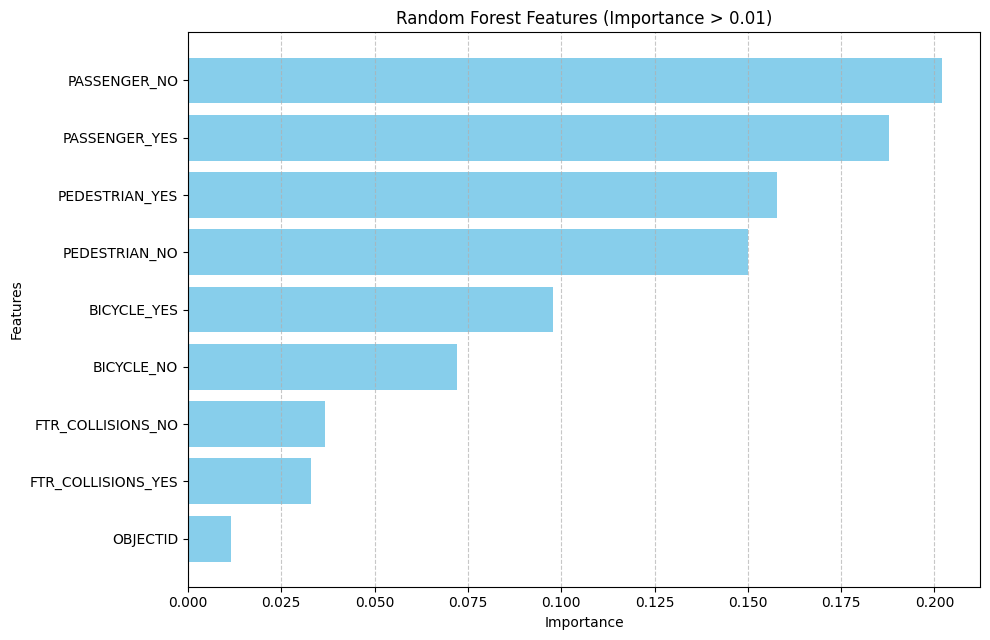

In [ ]:
# ===============================
# Random Forest Classifier & Feature Importance
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# 1. Build pipeline
rf_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("rf", RandomForestClassifier(
        n_estimators=100,       # 100 trees
        max_depth=10,           # Prevent overfitting
        min_samples_split=20,
        random_state=42,
        n_jobs=-1               # Use all CPUs
    ))
])

# 2. Train on training set
rf_pipe.fit(x_train, y_train)

# 3. Predictions
y_test_pred_rf = rf_pipe.predict(x_test)
class_index_rf = list(rf_pipe.classes_).index("SEVERE")
y_test_proba_rf = rf_pipe.predict_proba(x_test)[:, class_index_rf]

# --- PART A: Performance Evaluation ---

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_test_pred_rf, labels=["NON-SEVERE", "SEVERE"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                                 display_labels=["NON-SEVERE", "SEVERE"])
plt.figure(figsize=(5,4))
disp_rf.plot(values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Print Metrics
accuracy_rf  = accuracy_score(y_test, y_test_pred_rf)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label="SEVERE")
recall_rf    = recall_score(y_test, y_test_pred_rf, pos_label="SEVERE")
f1_rf        = f1_score(y_test, y_test_pred_rf, pos_label="SEVERE")
auc_rf       = roc_auc_score((y_test == "SEVERE").astype(int), y_test_proba_rf)

print("\n=== Random Forest Performance ===")
print(f"Accuracy : {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall   : {recall_rf:.4f}")
print(f"F1-score : {f1_rf:.4f}")
print(f"AUC-ROC  : {auc_rf:.4f}")

# ROC Curve
y_test_bin = (y_test == "SEVERE").astype(int)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_bin, y_test_proba_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

# --- PART B: Feature Importance (Filtered) ---

# Extract model and importances
rf_model = rf_pipe.named_steps["rf"]
importances = rf_model.feature_importances_

# Handle feature names
if hasattr(x_train, 'columns'):
    feature_names = x_train.columns
else:
    feature_names = [f"Feature {i}" for i in range(x_train.shape[1])]

# Create DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# ==========================================
# FILTER SETTINGS
# ==========================================
threshold = 0.01

# Filter the DataFrame
important_features = feature_imp_df[feature_imp_df['Importance'] > threshold].copy()
important_features = important_features.sort_values(by='Importance', ascending=True)

# 1. Print Table of Important Features
print(f"\n=== Features with Importance > {threshold} ===")
if not important_features.empty:
    # Printing in descending order for the table (easier to read)
    print(important_features.sort_values(by='Importance', ascending=False).to_string(index=False))
else:
    print("No features met the threshold.")

# 2. Plot Only Important Features
plt.figure(figsize=(10, len(important_features) * 0.5 + 2)) # Auto-adjust height
if not important_features.empty:
    plt.barh(important_features['Feature'], important_features['Importance'], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f"Random Forest Features (Importance > {threshold})")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot: No features met the threshold.")


<Figure size 500x400 with 0 Axes>

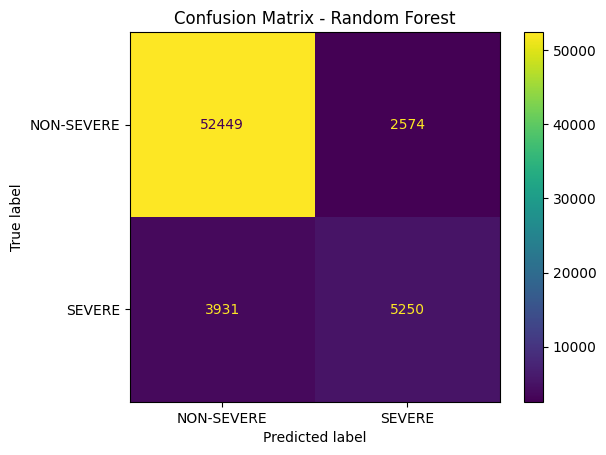


=== Adjusted Random Forest Performance ===
Accuracy : 0.8987
Precision: 0.6710
Recall   : 0.5718
F1-score : 0.6175
AUC-ROC  : 0.8353


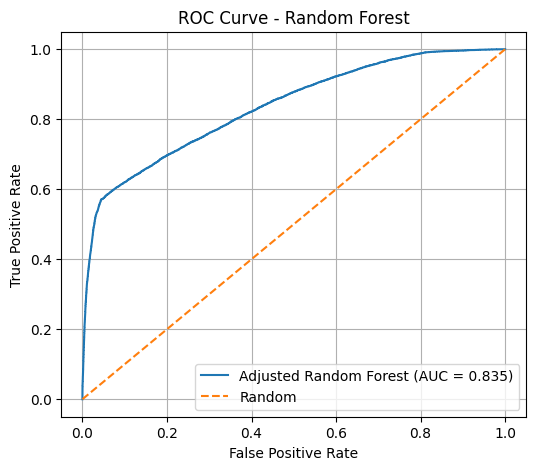


=== Features with Importance > 0.01 ===
           Feature  Importance
      PASSENGER_NO    0.204711
     PASSENGER_YES    0.195454
    PEDESTRIAN_YES    0.130996
     PEDESTRIAN_NO    0.113551
FTR_COLLISIONS_YES    0.082003
 FTR_COLLISIONS_NO    0.076761
       BICYCLE_YES    0.073676
        BICYCLE_NO    0.055298


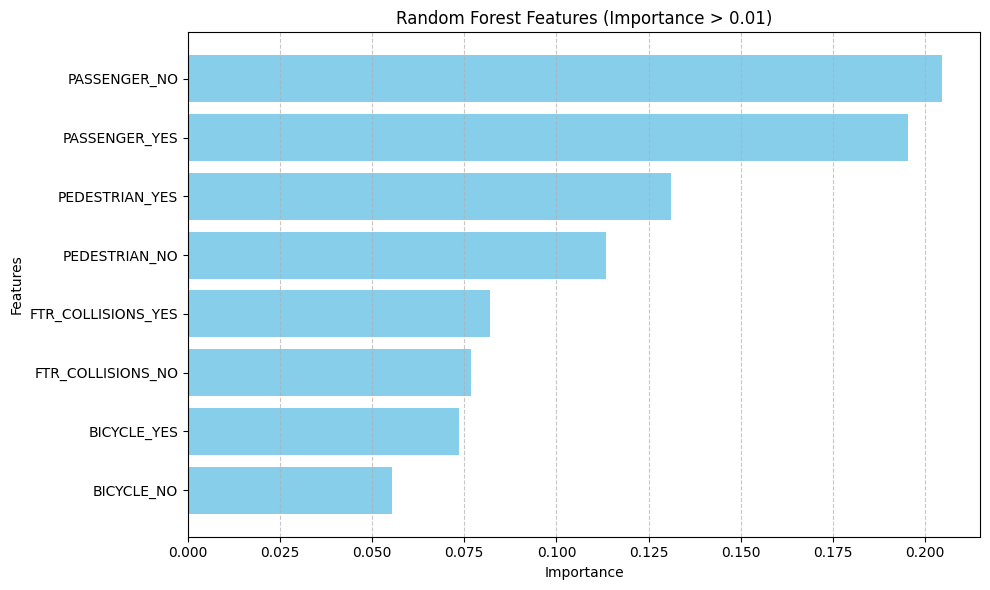

In [ ]:
# ===============================
# Adjusted Random Forest Classifier & Feature Importance
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# 1. Build pipeline
rfa_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("rf", RandomForestClassifier(
        n_estimators=100,       # 100 trees
        max_depth=10,           # Prevent overfitting
        min_samples_split=20,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1               # Use all CPUs
    ))
])

# 2. Train on training set
rfa_pipe.fit(x_train, y_train)

# 3. Predictions
y_test_pred_rfa = rfa_pipe.predict(x_test)
class_index_rfa = list(rfa_pipe.classes_).index("SEVERE")
y_test_proba_rfa = rfa_pipe.predict_proba(x_test)[:, class_index_rfa]

# --- PART A: Performance Evaluation ---

# Confusion Matrix
cm_rfa = confusion_matrix(y_test, y_test_pred_rfa, labels=["NON-SEVERE", "SEVERE"])
disp_rfa = ConfusionMatrixDisplay(confusion_matrix=cm_rfa,
                                 display_labels=["NON-SEVERE", "SEVERE"])
plt.figure(figsize=(5,4))
disp_rfa.plot(values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Print Metrics
accuracy_rfa  = accuracy_score(y_test, y_test_pred_rfa)
precision_rfa = precision_score(y_test, y_test_pred_rfa, pos_label="SEVERE")
recall_rfa    = recall_score(y_test, y_test_pred_rfa, pos_label="SEVERE")
f1_rfa        = f1_score(y_test, y_test_pred_rfa, pos_label="SEVERE")
auc_rfa       = roc_auc_score((y_test == "SEVERE").astype(int), y_test_proba_rfa)

print("\n=== Adjusted Random Forest Performance ===")
print(f"Accuracy : {accuracy_rfa:.4f}")
print(f"Precision: {precision_rfa:.4f}")
print(f"Recall   : {recall_rfa:.4f}")
print(f"F1-score : {f1_rfa:.4f}")
print(f"AUC-ROC  : {auc_rfa:.4f}")

# ROC Curve
y_test_bin = (y_test == "SEVERE").astype(int)
fpr_rfa, tpr_rfa, thresholds_rfa = roc_curve(y_test_bin, y_test_proba_rfa)

plt.figure(figsize=(6,5))
plt.plot(fpr_rfa, tpr_rfa, label=f"Adjusted Random Forest (AUC = {auc_rfa:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

# --- PART B: Feature Importance (Filtered) ---

# Extract model and importances
rfa_model = rfa_pipe.named_steps["rf"]
importances = rfa_model.feature_importances_

# Handle feature names
if hasattr(x_train, 'columns'):
    feature_names = x_train.columns
else:
    feature_names = [f"Feature {i}" for i in range(x_train.shape[1])]

# Create DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# ==========================================
# FILTER SETTINGS
# ==========================================
threshold = 0.01  # <--- CHANGE THIS VALUE (e.g., 0.01 means 1% importance)

# Filter the DataFrame
important_features = feature_imp_df[feature_imp_df['Importance'] > threshold].copy()
important_features = important_features.sort_values(by='Importance', ascending=True)

# 1. Print Table of Important Features
print(f"\n=== Features with Importance > {threshold} ===")
if not important_features.empty:
    # Printing in descending order for the table (easier to read)
    print(important_features.sort_values(by='Importance', ascending=False).to_string(index=False))
else:
    print("No features met the threshold.")

# 2. Plot Only Important Features
plt.figure(figsize=(10, len(important_features) * 0.5 + 2)) # Auto-adjust height
if not important_features.empty:
    plt.barh(important_features['Feature'], important_features['Importance'], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f"Random Forest Features (Importance > {threshold})")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot: No features met the threshold.")


<Figure size 500x400 with 0 Axes>

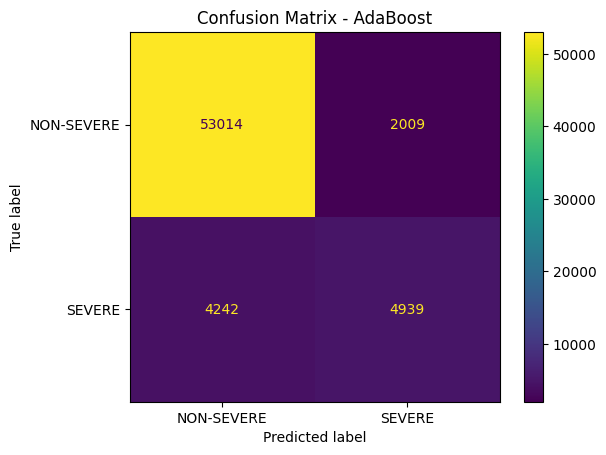


=== AdaBoost Performance ===
Accuracy : 0.9026
Precision: 0.7109
Recall   : 0.5380
F1-score : 0.6124
AUC-ROC  : 0.8253


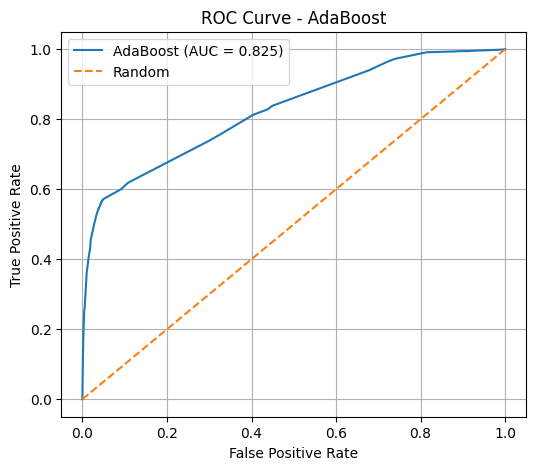


=== Features with Importance > 0.01 ===
           Feature  Importance
      PASSENGER_NO    0.223975
    PEDESTRIAN_YES    0.171441
        BICYCLE_NO    0.147469
       BICYCLE_YES    0.101667
     PEDESTRIAN_NO    0.100412
FTR_COLLISIONS_YES    0.093292
     MOTORCYCLE_NO    0.058820
    MOTORCYCLE_YES    0.052775
          OBJECTID    0.024613
         LAT_WGS84    0.010280


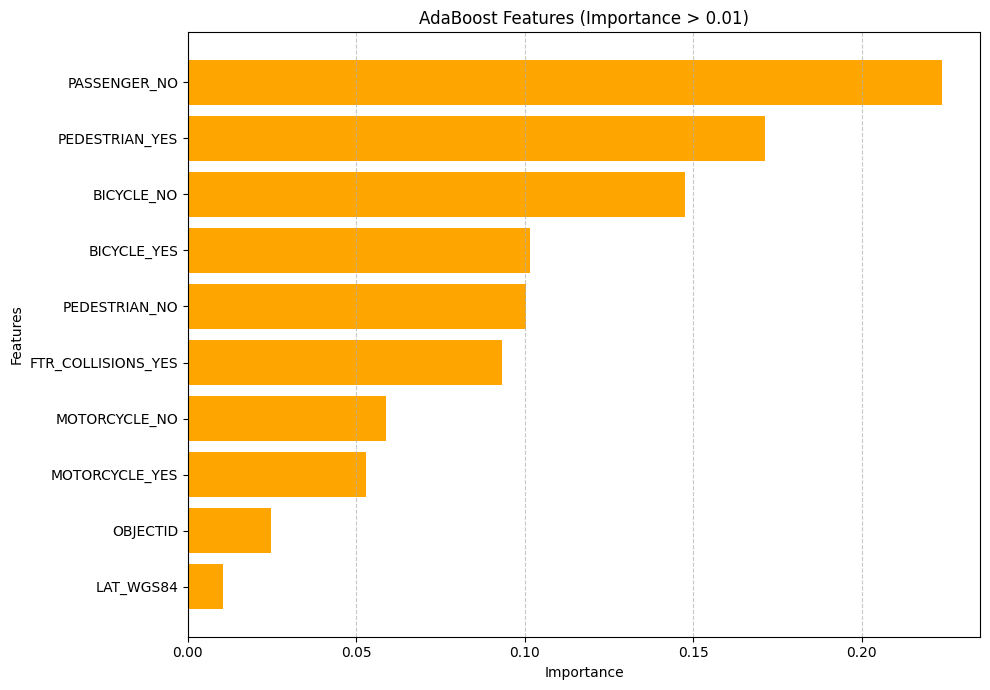

In [ ]:
# ===============================
# AdaBoost Classifier & Feature Importance
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# 1. Build pipeline
# AdaBoost uses Decision Stumps (depth=1) by default.
# You can customize the base_estimator if you want deeper trees.
ada_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("ada", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1), # Default is depth=1 (Stump)
        n_estimators=100,       # 100 boosting stages
        learning_rate=1.0,      # Weight applied to each classifier
        random_state=42
    ))
])

# 2. Train on training set
ada_pipe.fit(x_train, y_train)

# 3. Predictions
y_test_pred_ada = ada_pipe.predict(x_test)

# Get probabilities for "SEVERE"
class_index_ada = list(ada_pipe.classes_).index("SEVERE")
y_test_proba_ada = ada_pipe.predict_proba(x_test)[:, class_index_ada]

# --- PART A: Performance Evaluation ---

# Confusion Matrix
cm_ada = confusion_matrix(y_test, y_test_pred_ada, labels=["NON-SEVERE", "SEVERE"])
disp_ada = ConfusionMatrixDisplay(confusion_matrix=cm_ada,
                                 display_labels=["NON-SEVERE", "SEVERE"])
plt.figure(figsize=(5,4))
disp_ada.plot(values_format="d")
plt.title("Confusion Matrix - AdaBoost")
plt.show()

# Print Metrics
accuracy_ada  = accuracy_score(y_test, y_test_pred_ada)
precision_ada = precision_score(y_test, y_test_pred_ada, pos_label="SEVERE")
recall_ada    = recall_score(y_test, y_test_pred_ada, pos_label="SEVERE")
f1_ada        = f1_score(y_test, y_test_pred_ada, pos_label="SEVERE")
auc_ada       = roc_auc_score((y_test == "SEVERE").astype(int), y_test_proba_ada)

print("\n=== AdaBoost Performance ===")
print(f"Accuracy : {accuracy_ada:.4f}")
print(f"Precision: {precision_ada:.4f}")
print(f"Recall   : {recall_ada:.4f}")
print(f"F1-score : {f1_ada:.4f}")
print(f"AUC-ROC  : {auc_ada:.4f}")

# ROC Curve
y_test_bin = (y_test == "SEVERE").astype(int)
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test_bin, y_test_proba_ada)

plt.figure(figsize=(6,5))
plt.plot(fpr_ada, tpr_ada, label=f"AdaBoost (AUC = {auc_ada:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost")
plt.legend()
plt.grid(True)
plt.show()

# --- PART B: Feature Importance (Filtered) ---

# Extract model and importances
# Access the step named "ada"
ada_model = ada_pipe.named_steps["ada"]
importances = ada_model.feature_importances_

# Handle feature names
if hasattr(x_train, 'columns'):
    feature_names = x_train.columns
else:
    feature_names = [f"Feature {i}" for i in range(x_train.shape[1])]

# Create DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# ==========================================
# FILTER SETTINGS
# ==========================================
threshold = 0.01

# Filter the DataFrame
important_features = feature_imp_df[feature_imp_df['Importance'] > threshold].copy()
important_features = important_features.sort_values(by='Importance', ascending=True)

# 1. Print Table
print(f"\n=== Features with Importance > {threshold} ===")
if not important_features.empty:
    print(important_features.sort_values(by='Importance', ascending=False).to_string(index=False))
else:
    print("No features met the threshold.")

# 2. Plot Only Important Features
plt.figure(figsize=(10, len(important_features) * 0.5 + 2))
if not important_features.empty:
    plt.barh(important_features['Feature'], important_features['Importance'], color='orange')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f"AdaBoost Features (Importance > {threshold})")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot: No features met the threshold.")

In [ ]:
# ===============================
# Adjusted Random Forest Classifier & Feature Importance
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# 1. Build pipeline
rfa_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("rf", RandomForestClassifier(
        n_estimators=100,       # 100 trees
        max_depth=10,           # Prevent overfitting
        min_samples_split=20,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1               # Use all CPUs
    ))
])

# 2. Train on training set
rfa_pipe.fit(x_train, y_train)

# 3. Predictions
y_test_pred_rfa = rfa_pipe.predict(x_test)
class_index_rfa = list(rfa_pipe.classes_).index("SEVERE")
y_test_proba_rfa = rfa_pipe.predict_proba(x_test)[:, class_index_rfa]

# --- PART A: Performance Evaluation ---

# Confusion Matrix
cm_rfa = confusion_matrix(y_test, y_test_pred_rfa, labels=["NON-SEVERE", "SEVERE"])
disp_rfa = ConfusionMatrixDisplay(confusion_matrix=cm_rfa,
                                 display_labels=["NON-SEVERE", "SEVERE"])
plt.figure(figsize=(5,4))
disp_rfa.plot(values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Print Metrics
accuracy_rfa  = accuracy_score(y_test, y_test_pred_rfa)
precision_rfa = precision_score(y_test, y_test_pred_rfa, pos_label="SEVERE")
recall_rfa    = recall_score(y_test, y_test_pred_rfa, pos_label="SEVERE")
f1_rfa        = f1_score(y_test, y_test_pred_rfa, pos_label="SEVERE")
auc_rfa       = roc_auc_score((y_test == "SEVERE").astype(int), y_test_proba_rfa)

print("\n=== Adjusted Random Forest Performance ===")
print(f"Accuracy : {accuracy_rfa:.4f}")
print(f"Precision: {precision_rfa:.4f}")
print(f"Recall   : {recall_rfa:.4f}")
print(f"F1-score : {f1_rfa:.4f}")
print(f"AUC-ROC  : {auc_rfa:.4f}")

# ROC Curve
y_test_bin = (y_test == "SEVERE").astype(int)
fpr_rfa, tpr_rfa, thresholds_rfa = roc_curve(y_test_bin, y_test_proba_rfa)

plt.figure(figsize=(6,5))
plt.plot(fpr_rfa, tpr_rfa, label=f"Adjusted Random Forest (AUC = {auc_rfa:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

# --- PART B: Feature Importance (Filtered) ---

# Extract model and importances
rfa_model = rfa_pipe.named_steps["rf"]
importances = rfa_model.feature_importances_

# Handle feature names
if hasattr(x_train, 'columns'):
    feature_names = x_train.columns
else:
    feature_names = [f"Feature {i}" for i in range(x_train.shape[1])]

# Create DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# ==========================================
# FILTER SETTINGS
# ==========================================
threshold = 0.01  # <--- CHANGE THIS VALUE (e.g., 0.01 means 1% importance)

# Filter the DataFrame
important_features = feature_imp_df[feature_imp_df['Importance'] > threshold].copy()
important_features = important_features.sort_values(by='Importance', ascending=True)

# 1. Print Table of Important Features
print(f"\n=== Features with Importance > {threshold} ===")
if not important_features.empty:
    # Printing in descending order for the table (easier to read)
    print(important_features.sort_values(by='Importance', ascending=False).to_string(index=False))
else:
    print("No features met the threshold.")

# 2. Plot Only Important Features
plt.figure(figsize=(10, len(important_features) * 0.5 + 2)) # Auto-adjust height
if not important_features.empty:
    plt.barh(important_features['Feature'], important_features['Importance'], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f"Random Forest Features (Importance > {threshold})")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot: No features met the threshold.")


NOW WITH WEATHER

In [ ]:
#Data Cleaning

import pandas as pd
import numpy as np

# 1. Load the dataset
df = pd.read_csv("Traffic_Collisions_With_Weather_Patched.csv")

# 2. Remove entries where HOOD or NEIGHBOURHOOD are "NSA"
df = df[
    (df["HOOD_158"] != "NSA") &
    (df["NEIGHBOURHOOD_158"] != "NSA") &
    (df["DIVISION"] != "NSA") &
    (df["AUTOMOBILE"] != "N/R") &
    (df["MOTORCYCLE"] != "N/R") &
    (df["BICYCLE"] != "N/R") &
    (df["PEDESTRIAN"] != "N/R")
]

# 3. Remove any rows with missing data in ANY remaining column
df = df.dropna()

# 4. Create the new 'severity' classification
#    - severe: any fatalities OR any injuries
#    - non-severe: everything else
df["SEVERITY"] = np.where(
    (df["FATALITIES"] > 0) | (df["INJURY_COLLISIONS"] == "YES"),
    "SEVERE",
    "NON-SEVERE"
)

# 5. Drop the original severity-related columns
df = df.drop(columns=["LONG_WGS84","LAT_WGS84","x","y","merge_key","date_clean","hour_clean","weather_datetime","HOOD_158","FATALITIES", "INJURY_COLLISIONS", "PD_COLLISIONS", "EVENT_UNIQUE_ID", "OCC_DATE"])

# 6. Optional: save the cleaned, modified dataset
df.to_csv("Traffic_Collisions_With_Weather_Patched_clean_severity_no_NSA_hood.csv", index=False)

print("=== BASIC STATISTICS ===")
print("\nDataset Info:")
print(df.info())

print("\n=== DESCRIPTIVE STATISTICS FOR NUMERICAL COLUMNS ===")
print(df.describe())

print("\n=== MISSING DATA ANALYSIS ===")
print("Missing values per column:")
print(df.isnull().sum())

print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Percentage of missing data: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")

print("\n=== DATA TYPES ===")
print(df.dtypes)
print(df["SEVERITY"].value_counts())
# Quick peek
df.head()

=== BASIC STATISTICS ===

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 642036 entries, 0 to 772514
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   OBJECTID           642036 non-null  int64  
 1   OCC_MONTH          642036 non-null  object 
 2   OCC_DOW            642036 non-null  object 
 3   OCC_YEAR           642036 non-null  int64  
 4   OCC_HOUR           642036 non-null  int64  
 5   DIVISION           642036 non-null  object 
 6   FTR_COLLISIONS     642036 non-null  object 
 7   NEIGHBOURHOOD_158  642036 non-null  object 
 8   AUTOMOBILE         642036 non-null  object 
 9   MOTORCYCLE         642036 non-null  object 
 10  PASSENGER          642036 non-null  object 
 11  BICYCLE            642036 non-null  object 
 12  PEDESTRIAN         642036 non-null  object 
 13  temperature        642036 non-null  float64
 14  precipitation      642036 non-null  float64
 15  visibility      

,OBJECTID,OCC_MONTH,OCC_DOW,OCC_YEAR,OCC_HOUR,DIVISION,FTR_COLLISIONS,NEIGHBOURHOOD_158,AUTOMOBILE,MOTORCYCLE,PASSENGER,BICYCLE,PEDESTRIAN,temperature,precipitation,visibility,weather_desc,SEVERITY
0,1,January,Wednesday,2014,17,D53,YES,Mount Pleasant East (99),YES,NO,NO,NO,NO,-14.0,0.0,24.1,Mostly Cloudy,NON-SEVERE
1,2,January,Wednesday,2014,14,D32,NO,Lawrence Park North (105),YES,NO,NO,NO,NO,-12.5,0.0,24.1,Cloudy,NON-SEVERE
13,14,January,Wednesday,2014,4,D33,NO,Fenside-Parkwoods (150),YES,NO,NO,NO,NO,-11.3,0.0,24.1,Mainly Clear,NON-SEVERE
14,15,January,Wednesday,2014,11,D53,YES,Thorncliffe Park (55),YES,NO,NO,NO,NO,-10.7,0.0,24.1,Cloudy,NON-SEVERE
15,16,January,Wednesday,2014,1,D52,NO,Downtown Yonge East (168),YES,NO,NO,NO,NO,-10.1,0.0,24.1,Mainly Clear,NON-SEVERE


In [ ]:
# Feature Analysis

# Target (no one-hot needed)
y = df["SEVERITY"]

# Features
x = df.drop(columns=["SEVERITY"])

# One-hot encode *feature* columns that are strings
cat_cols = x.select_dtypes(include=["object", "string"]).columns
xw_encoded = pd.get_dummies(x, columns=cat_cols, drop_first=False)

print("Categorical columns being one-hot encoded:")
print(cat_cols)

# Train, validation, test split

from sklearn.model_selection import train_test_split

xw_train, xw_temp, yw_train, yw_temp = train_test_split(
    xw_encoded,y, test_size=0.3, random_state=42
    )

xw_val, xw_test, yw_val, yw_test = train_test_split(
    xw_temp, yw_temp, test_size=1/3, random_state=42
)

print(f"Train size: {xw_train.shape[0]}")
print(f"Validation size: {xw_val.shape[0]}")
print(f"Test size: {xw_test.shape[0]}")

Categorical columns being one-hot encoded:
Index(['OCC_MONTH', 'OCC_DOW', 'DIVISION', 'FTR_COLLISIONS',
       'NEIGHBOURHOOD_158', 'AUTOMOBILE', 'MOTORCYCLE', 'PASSENGER', 'BICYCLE',
       'PEDESTRIAN', 'weather_desc'],
      dtype='object')
Train size: 449425
Validation size: 128407
Test size: 64204


<Figure size 500x400 with 0 Axes>

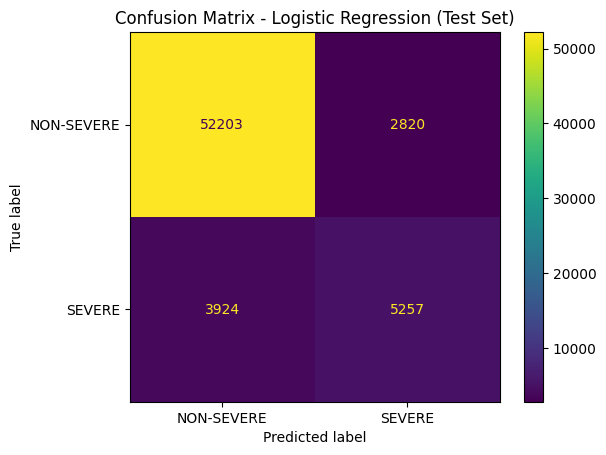

Accuracy : 0.8950
Precision: 0.6509
Recall   : 0.5726
F1-score : 0.6092
AUC-ROC  : 0.8285


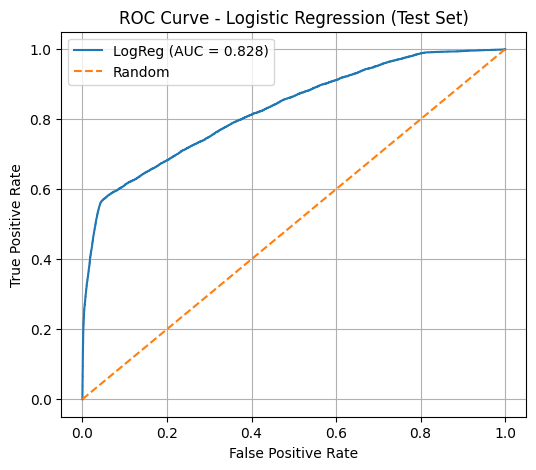

In [ ]:
# Logistic Regression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

# Build pipeline: scale → logistic regression
log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

# Train on training set
log_reg_pipe.fit(xw_train, yw_train)

# Evaluate on validation set
yw_val_pred = log_reg_pipe.predict(xw_val)


# --- Predictions ---
yw_test_pred = log_reg_pipe.predict(xw_test)

# For ROC/AUC we need predicted probabilities for the positive class ("SEVERE")
# Pipeline has classes_ in order, so we find the index of "SEVERE"
class_index = list(log_reg_pipe.classes_).index("SEVERE")
yw_test_proba = log_reg_pipe.predict_proba(xw_test)[:, class_index]

# --- Confusion matrix ---
cm = confusion_matrix(yw_test, yw_test_pred, labels=["NON-SEVERE", "SEVERE"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["NON-SEVERE", "SEVERE"])
plt.figure(figsize=(5,4))
disp.plot(values_format="d")
plt.title("Confusion Matrix - Logistic Regression (Test Set)")
plt.show()

# --- Metrics ---
accuracy = accuracy_score(yw_test, yw_test_pred)
precision = precision_score(yw_test, yw_test_pred, pos_label="SEVERE")
recall = recall_score(yw_test, yw_test_pred, pos_label="SEVERE")
f1 = f1_score(yw_test, yw_test_pred, pos_label="SEVERE")
auc = roc_auc_score((yw_test == "SEVERE").astype(int), yw_test_proba)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}")

# Compute ROC curve
yw_test_bin = (y_test == "SEVERE").astype(int)
fpr, tpr, thresholds = roc_curve(yw_test_bin, yw_test_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

Starting training...
Training complete.


<Figure size 500x400 with 0 Axes>

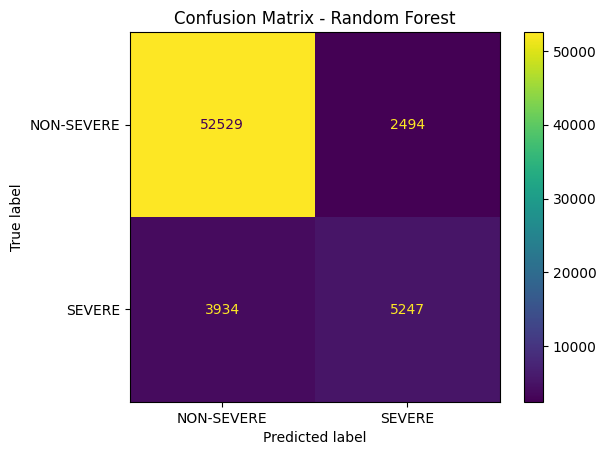


=== Adjusted Random Forest Performance ===
Accuracy : 0.8999
Precision: 0.6778
Recall   : 0.5715
F1-score : 0.6201
AUC-ROC  : 0.8360


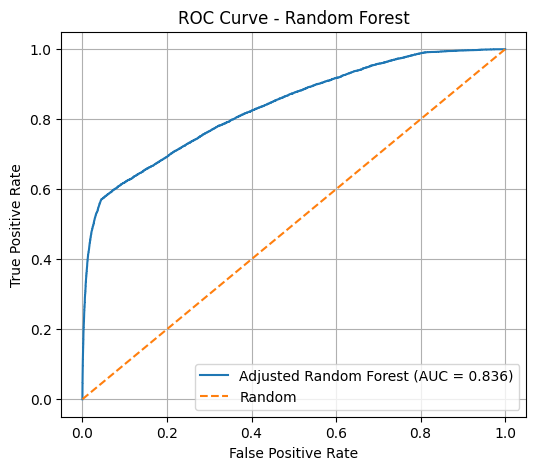


=== Features with Importance > 0.01 ===
           Feature  Importance
      PASSENGER_NO    0.224134
     PASSENGER_YES    0.145604
    PEDESTRIAN_YES    0.131936
     PEDESTRIAN_NO    0.130689
 FTR_COLLISIONS_NO    0.093456
FTR_COLLISIONS_YES    0.075497
        BICYCLE_NO    0.074655
       BICYCLE_YES    0.066782


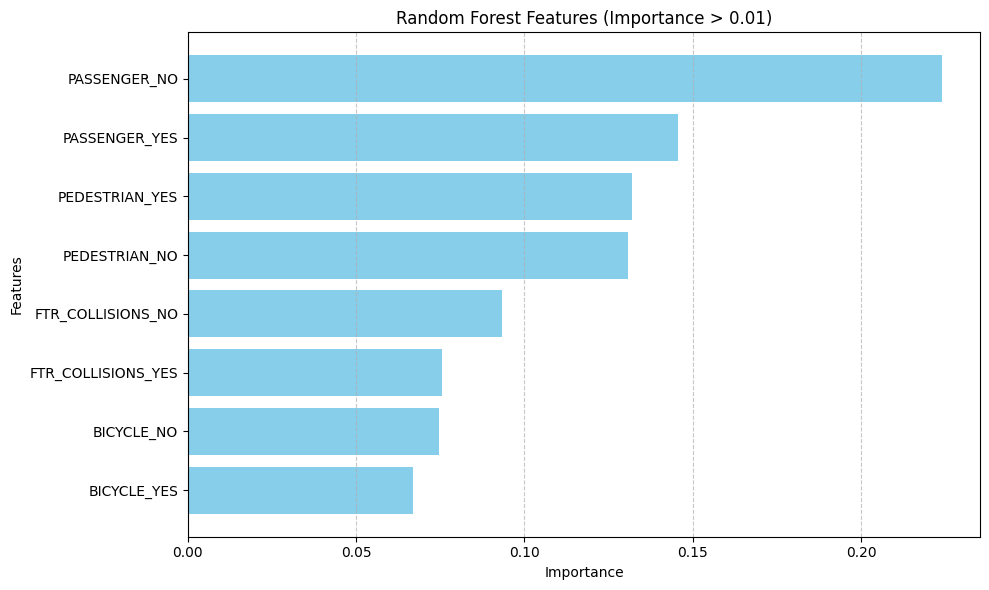

In [ ]:
# ===============================
# Adjusted Random Forest Classifier & Feature Importance
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# 1. Build pipeline
rfa_pipe = Pipeline([
    ("rf", RandomForestClassifier(
        n_estimators=100,
        max_depth=10,           # Prevent overfitting
        min_samples_split=20,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1               # Use all CPUs
    ))
])

# 2. Train on training set (Using xw_train, yw_train)
print("Starting training...")
rfa_pipe.fit(xw_train, yw_train)
print("Training complete.")

# 3. Predictions (Using xw_test)
y_test_pred_rfa = rfa_pipe.predict(xw_test)
class_index_rfa = list(rfa_pipe.classes_).index("SEVERE")
y_test_proba_rfa = rfa_pipe.predict_proba(xw_test)[:, class_index_rfa]

# --- PART A: Performance Evaluation ---

# Confusion Matrix (Using yw_test)
cm_rfa = confusion_matrix(yw_test, y_test_pred_rfa, labels=["NON-SEVERE", "SEVERE"])
disp_rfa = ConfusionMatrixDisplay(confusion_matrix=cm_rfa,
                                 display_labels=["NON-SEVERE", "SEVERE"])
plt.figure(figsize=(5,4))
disp_rfa.plot(values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Print Metrics (Using yw_test)
accuracy_rfa  = accuracy_score(yw_test, y_test_pred_rfa)
precision_rfa = precision_score(yw_test, y_test_pred_rfa, pos_label="SEVERE")
recall_rfa    = recall_score(yw_test, y_test_pred_rfa, pos_label="SEVERE")
f1_rfa        = f1_score(yw_test, y_test_pred_rfa, pos_label="SEVERE")
auc_rfa       = roc_auc_score((yw_test == "SEVERE").astype(int), y_test_proba_rfa)

print("\n=== Adjusted Random Forest Performance ===")
print(f"Accuracy : {accuracy_rfa:.4f}")
print(f"Precision: {precision_rfa:.4f}")
print(f"Recall   : {recall_rfa:.4f}")
print(f"F1-score : {f1_rfa:.4f}")
print(f"AUC-ROC  : {auc_rfa:.4f}")

# ROC Curve
y_test_bin = (yw_test == "SEVERE").astype(int)
fpr_rfa, tpr_rfa, thresholds_rfa = roc_curve(y_test_bin, y_test_proba_rfa)

plt.figure(figsize=(6,5))
plt.plot(fpr_rfa, tpr_rfa, label=f"Adjusted Random Forest (AUC = {auc_rfa:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

# --- PART B: Feature Importance (Filtered) ---

# Extract model and importances
rfa_model = rfa_pipe.named_steps["rf"]
importances = rfa_model.feature_importances_

# Handle feature names using xw_train
if hasattr(xw_train, 'columns'):
    feature_names = xw_train.columns
else:
    feature_names = [f"Feature {i}" for i in range(xw_train.shape[1])]

# Create DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# ==========================================
# FILTER SETTINGS
# ==========================================
threshold = 0.01  # <--- CHANGE THIS VALUE (e.g., 0.01 means 1% importance)

# Filter the DataFrame
important_features = feature_imp_df[feature_imp_df['Importance'] > threshold].copy()
important_features = important_features.sort_values(by='Importance', ascending=True)

# 1. Print Table of Important Features
print(f"\n=== Features with Importance > {threshold} ===")
if not important_features.empty:
    # Printing in descending order for the table (easier to read)
    print(important_features.sort_values(by='Importance', ascending=False).to_string(index=False))
else:
    print("No features met the threshold.")

# 2. Plot Only Important Features
plt.figure(figsize=(10, len(important_features) * 0.5 + 2)) # Auto-adjust height
if not important_features.empty:
    plt.barh(important_features['Feature'], important_features['Importance'], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f"Random Forest Features (Importance > {threshold})")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot: No features met the threshold.")

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 500x400 with 0 Axes>

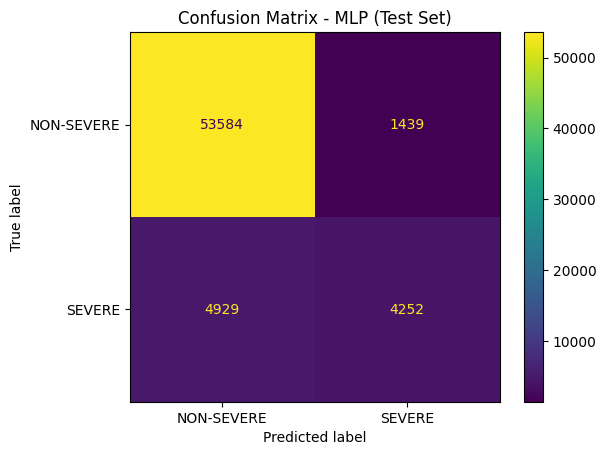

=== MLP Performance on Test Set ===
Accuracy : 0.9008
Precision: 0.7471
Recall   : 0.4631
F1-score : 0.5718
AUC-ROC  : 0.8148


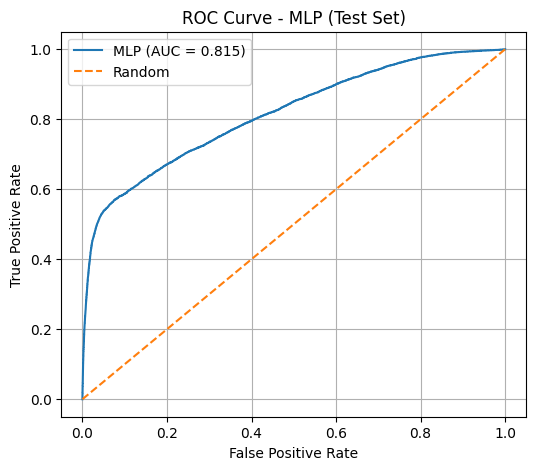

In [13]:
# ============================
# Neural Network (MLP)
# ============================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

# Build pipeline: scale → MLP
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        max_iter=100,
        random_state=42
    ))
])

# Train on training set
mlp_pipe.fit(xw_train, yw_train)

# --- Predictions on test set ---
yw_test_pred_mlp = mlp_pipe.predict(xw_test)

# For ROC/AUC we need predicted probabilities for "SEVERE"
class_index_mlp = list(mlp_pipe.classes_).index("SEVERE")
yw_test_proba_mlp = mlp_pipe.predict_proba(xw_test)[:, class_index_mlp]

# --- Confusion matrix ---
cm_mlp = confusion_matrix(yw_test, yw_test_pred_mlp, labels=["NON-SEVERE", "SEVERE"])
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp,
                                  display_labels=["NON-SEVERE", "SEVERE"])
plt.figure(figsize=(5,4))
disp_mlp.plot(values_format="d")
plt.title("Confusion Matrix - MLP (Test Set)")
plt.show()

# --- Metrics ---
accuracy_mlp  = accuracy_score(yw_test, yw_test_pred_mlp)
precision_mlp = precision_score(yw_test, yw_test_pred_mlp, pos_label="SEVERE")
recall_mlp    = recall_score(yw_test, yw_test_pred_mlp, pos_label="SEVERE")
f1_mlp        = f1_score(yw_test, yw_test_pred_mlp, pos_label="SEVERE")
auc_mlp       = roc_auc_score((yw_test == "SEVERE").astype(int), yw_test_proba_mlp)

print("=== MLP Performance on Test Set ===")
print(f"Accuracy : {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall   : {recall_mlp:.4f}")
print(f"F1-score : {f1_mlp:.4f}")
print(f"AUC-ROC  : {auc_mlp:.4f}")

# --- ROC curve ---
yw_test_bin = (yw_test == "SEVERE").astype(int)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(yw_test_bin, yw_test_proba_mlp)

plt.figure(figsize=(6,5))
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {auc_mlp:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP (Test Set)")
plt.legend()
plt.grid(True)
plt.show()
